<p>For this problem you will use a different subset of the 20 Newsgroup data set that you used in Assignment 2  (see the description of the full dataset). The subset for this assignment includes 2,500 documents (newsgroup posts), each belonging to one of 5 categories windows (0), crypt (1), christian (2), hockey (3), forsale (4). The documents are represented by 9328 terms (stems). The dictionary (vocabulary) for the data set is given in the file "terms.txt" and the full term-by-document matrix is given in "matrix.txt" (comma separated values). The actual category labels for the documents are provided in the file "classes.txt". Your goal in this assignment is to perform clustering on the documents and compare the clusters to the actual categories.

Your tasks in this problem are the following [Note: for the clustering part of this assignment you should use the kMeans module form Ch. 10 of MLA (use the version provided here as it includes some corrections to the book version). You may also use Pandas and other modules from scikit-learn that you may need for preprocessing or evaluation.] </p>

In [1]:
# load the necessary packages
# load the necessary packages
import numpy as np
import pandas as pd
import operator
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor
from sklearn.model_selection import train_test_split 
import pylab as pl
from sklearn import feature_selection
from sklearn import model_selection
plt.style.use('ggplot')

##### a. Create your own distance function that, instead of using Euclidean distance, uses Cosine similarity. This is the distance function you will use to pass to the kMeans function.

In [2]:
'''
k Means Clustering for Ch10 of Machine Learning in Action
@author: Peter Harrington
'''
from numpy import *

def distEuclid(vecA, vecB):
    return sqrt(sum(power(vecA - vecB, 2))) #la.norm(vecA-vecB)

In [3]:
def cosineDist(vecA, vecB):
    """Function that returns cosine Similarity"""
    a_norm = np.linalg.norm(vecA)
    b_norm = np.linalg.norm(vecB)
    
    cosine = np.dot(vecA, vecB) / (a_norm * b_norm)
    dist = 1 - cosine
    
    return dist

In [4]:
def randCent(dataSet, k):
    '''
    randCent(), creates a set of k ran-dom  centroids  for  a  given  dataset.  
    The  random  centroids  need  to  be  within  thebounds of the dataset. 
    This is accomplished by finding the minimum and maximumvalues of each dimension 
    in the dataset. 
    Random values from 0 to 1.0 are then chosenand  scaled  by  the  range  and  
    minimum  value  to  ensure  that  the  random  points  arewithin  the  bounds  
    of  the  data.  
    '''
    n = shape(dataSet)[1]
    centroids = zeros((k,n), dtype=float)
    for j in range(n): #create random cluster centers
        minJ = min(dataSet[:,j])
        rangeJ = float(max(dataSet[:,j]) - minJ)
        centroids[:,j] = minJ + rangeJ * random.rand(k)
    return centroids 

In [5]:
# kMeans function
def kMeans(dataSet, k, distMeas=distEuclid, createCent=randCent):
    m = shape(dataSet)[0]
    clusterAssment = zeros((m,2)) #create mat to assign data points 
                                  #to a centroid, also holds SE of each point
    centroids = createCent(dataSet, k)
    clusterChanged = True
    while clusterChanged:
        clusterChanged = False
        for i in range(m): #for each data point assign it to the closest centroid
            minDist = inf; minIndex = -1
            for j in range(k):  #find the closest distance
                distJI = distMeas(centroids[j,:],dataSet[i,:])
                if distJI < minDist:
                    minDist = distJI; minIndex = j
            if clusterAssment[i,0] != minIndex: clusterChanged = True
            clusterAssment[i,:] = minIndex,minDist**2
        # print centroids
        for cent in range(k):#recalculate centroids and update the centroid location
            ptsInClust = dataSet[nonzero(clusterAssment[:,0]==cent)[0]] #get all the point in this cluster - Note: this was incorrect in the original distribution.
            if(len(ptsInClust)!=0):
                centroids[cent,:] = mean(ptsInClust, axis=0) #assign centroid to mean - Note condition was added 10/28/2013
    return centroids, clusterAssment

In [6]:
def biKmeans(dataSet, k, distMeas=distEuclid):
    '''
    To overcome the problem of poor clusters because of k-means getting caught in a local minimum, another algorithm has been developed. This algorithm, known as bisecting k-means, starts out with one cluster and then splits the cluster in two. It then chooses a cluster to split. The cluster to split is decided by minimizing the SSE. This splitting based on the SSE is repeated until the user-defined number of clusters is attained.
    '''
    m = shape(dataSet)[0]
    clusterAssment = mat(zeros((m,2))) # cluster assessment has two columns, one column is for the index of the cluster and the second column is store the error. 
    # This error is the distance from the cluster centroid to the current point. We’ll use this error later on to measure how good our clusters are
    centroid0 = mean(dataSet, axis=0).tolist()[0]
    centList =[centroid0] #create a list with one centroid
    for j in range(m): #calc initial Error
        clusterAssment[j,1] = distMeas(mat(centroid0), dataSet[j,:])**2
    while (len(centList) < k):
        lowestSSE = inf
        for i in range(len(centList)):
            ptsInCurrCluster = dataSet[nonzero(clusterAssment[:,0].A==i)[0],:] #get the data points currently in cluster i
            centroidMat, splitClustAss = kMeans(ptsInCurrCluster, 2, distMeas)
            sseSplit = sum(splitClustAss[:,1]) #compare the SSE to the currrent minimum
            sseNotSplit = sum(clusterAssment[nonzero(clusterAssment[:,0].A!=i)[0],1])
            print("sseSplit, and notSplit: ",sseSplit,sseNotSplit)
            if (sseSplit + sseNotSplit) < lowestSSE:
                bestCentToSplit = i
                bestNewCents = centroidMat
                bestClustAss = splitClustAss.copy()
                lowestSSE = sseSplit + sseNotSplit
        bestClustAss[nonzero(bestClustAss[:,0] == 1)[0],0] = len(centList) #change 1 to 3,4, or whatever
        bestClustAss[nonzero(bestClustAss[:,0] == 0)[0],0] = bestCentToSplit
        print('the bestCentToSplit is: ',bestCentToSplit)
        print('the len of bestClustAss is: ', len(bestClustAss))
        centList[bestCentToSplit] = bestNewCents[0,:].tolist()[0] #replace a centroid with two best centroids 
        centList.append(bestNewCents[1,:].tolist()[0])
        clusterAssment[nonzero(clusterAssment[:,0].A == bestCentToSplit)[0],:]= bestClustAss #reassign new clusters, and SSE
    return mat(centList), clusterAssment


#### b. Load the data set [Note: the data matrix provided has terms as rows and documents as columns. Since you will be clustering documents, you'll need to take the transpose of this matrix so that your main data matrix is a document x term matrix. In Numpy, you may use the ".T" operation to obtain the transpose.] Then, split the data set (the document x term matrix) and set aside 20% for later use (see below). Use the 80% segment for clustering in the next part. The 20% portion must be a random subset. Next, as in the previous assignment, perform TFxIDF transformation on these data sets

In [7]:
### load the data set
fileName_Classes = r'../../data/newsgroups5/classes.txt'
df_classes = pd.read_csv(fileName_Classes, header = None, skiprows = 1, index_col = 0)
df_classes.head()

""
0
0 0
1 1
2 1
3 1
4 2


In [8]:
# pd.read_csv?

In [9]:
df_classes.shape

(2500, 0)

In [10]:
df_classes.head()

""
0
0 0
1 1
2 1
3 1
4 2


In [11]:
%time
fileName_matrix = r'../../data/newsgroups5/matrix.txt'
df_matrix = pd.read_csv(fileName_matrix, header = None)
df_matrix.head() # display the first five records

Wall time: 0 ns


,0,1,2,3,4,5,6,7,8,9,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
df_matrix.shape

(9328, 2500)

In [13]:
fileName_terms = r'../../data/newsgroups5/terms.txt'
df_terms = pd.read_csv(fileName_terms, header = None)
df_terms.head() # display the first five records

,0
0,aa
1,aargh
2,aaron
3,aaronc
4,ab


#### We need to add the terms frequency across the columns

In [14]:
termFreqs = df_matrix.sum(axis = 1) # adding in the column direction
termFreqs

0       16
1        6
2       82
3       12
4       30
        ..
9323     8
9324    50
9325    11
9326     6
9327    15
Length: 9328, dtype: int64

<p>aa appears times 16 times, aargh appears 6 times, aaron appears 12 times and so on.</p>

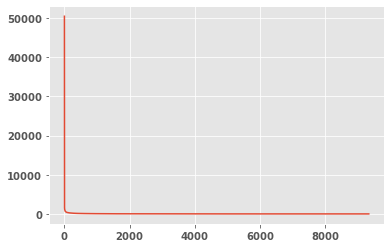

In [15]:
plt.plot(sorted(termFreqs, reverse=True))
plt.show()

#### Since we will be clustering documents, we'll need to take the transpose of this matrix so that our main data matrix is a document x term matrix. 

In [16]:
DT = df_matrix.T
DT.head()

,0,1,2,3,4,5,6,7,8,9,...,9318,9319,9320,9321,9322,9323,9324,9325,9326,9327
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
DT.shape

(2500, 9328)

#### We now have a document term matrix

In [18]:
numTerms = df_matrix.shape[0]
NDocs = df_matrix.shape[1]
print('There are %s terms.' %numTerms)
print('There are %s documents.' %NDocs)

There are 9328 terms.
There are 2500 documents.


#### Though TFxIDF weights are not necessary for clustering, we will transform the data to TFxIDF weights

In [19]:
matrix_DF = pd.DataFrame([(df_matrix != 0).sum(1)]).T
matrix_DF

,0
0,10
1,6
2,22
3,9
4,13
...,...
9323,6
9324,5
9325,3
9326,3


In [20]:
# create a matrix with all entries = NDocs
NMatrix=np.ones(np.shape(df_matrix), dtype = float) * NDocs
np.set_printoptions(precision = 2,suppress = True,linewidth = 120)
print(NMatrix)

[[2500. 2500. 2500. ... 2500. 2500. 2500.]
 [2500. 2500. 2500. ... 2500. 2500. 2500.]
 [2500. 2500. 2500. ... 2500. 2500. 2500.]
 ...
 [2500. 2500. 2500. ... 2500. 2500. 2500.]
 [2500. 2500. 2500. ... 2500. 2500. 2500.]
 [2500. 2500. 2500. ... 2500. 2500. 2500.]]


In [21]:
# Convert each entry into IDF values
# IDF is the log of the inverse of document frequency
# Note that IDF is only a function of the term, so all columns will be identical.
IDF = np.log2(np.divide(NMatrix, np.array(matrix_DF)))

np.set_printoptions(precision=2,suppress=True)
print(IDF)

[[7.97 7.97 7.97 ... 7.97 7.97 7.97]
 [8.7  8.7  8.7  ... 8.7  8.7  8.7 ]
 [6.83 6.83 6.83 ... 6.83 6.83 6.83]
 ...
 [9.7  9.7  9.7  ... 9.7  9.7  9.7 ]
 [9.7  9.7  9.7  ... 9.7  9.7  9.7 ]
 [9.29 9.29 9.29 ... 9.29 9.29 9.29]]


In [22]:
#### Finally computer the TF x IDF values for each document - term entry
TD_tfidf = df_matrix * IDF

In [23]:
pd.set_option("display.precision", 2)

TD_tfidf

,0,1,2,3,4,5,6,7,8,9,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9323,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9324,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9325,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9326,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
type(TD_tfidf)

pandas.core.frame.DataFrame

#### We also need to transpose the TD_ftidf matrix 

In [25]:
TD_tfidf_tranposed = TD_tfidf.T

#### create a 20%-80% randomized split of the data for later use.

In [26]:
# train_test_split shuffles the data and splits it into two split for us into 80% training and 20% percent testing.
vs_train, vs_test, vs_target_train, vs_target_test = train_test_split(TD_tfidf_tranposed, df_classes, test_size = 0.2, random_state = 33)

#### let's look at the shapes of the training and test data matrices.

In [27]:

vs_train.shape

(2000, 9328)

In [28]:
vs_test.shape

(500, 9328)

In [29]:
vs_target_train.shape

(2000, 0)

In [30]:
vs_target_test.shape

(500, 0)

In [31]:
vs_train.head()

,0,1,2,3,4,5,6,7,8,9,...,9318,9319,9320,9321,9322,9323,9324,9325,9326,9327
1289,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
596,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1935,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2436,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2349,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
vs_test.head()

,0,1,2,3,4,5,6,7,8,9,...,9318,9319,9320,9321,9322,9323,9324,9325,9326,9327
1590,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
277,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2297,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
511,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
vs_target_train.head()

""
0
1289 4
596 0
1935 4
2436 4
2349 1


#### Convert the training and testing data matrices into numpy array

In [34]:
vs_train_array = np.array(vs_train)
vs_target_array = np.array(vs_target_test)

#### c. Perform Kmeans clustering on the transformed training data from part (b) [Note: if you have difficulty with TFxIDF conversion, then use the original non-transformed data for the remainder of this assignment].

In [35]:
%time
# (dataSet, k, distMeas=distEuclid, createCent=randCent)
centroids, clusterAssment = kMeans(vs_train_array, 5, cosineDist, randCent)

Wall time: 0 ns


In [36]:
centroids

array([[0.04, 0.  , 0.06, ..., 0.  , 0.  , 0.  ],
       [0.04, 0.  , 0.  , ..., 0.05, 0.03, 0.15],
       [0.  , 0.09, 0.02, ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 1.21, 0.  , 0.  ],
       [0.02, 0.  , 1.11, ..., 0.  , 0.  , 0.  ]])

In [37]:
clusterAssment

array([[0.  , 0.87],
       [2.  , 0.9 ],
       [0.  , 0.81],
       ...,
       [4.  , 0.31],
       [0.  , 0.63],
       [1.  , 0.73]])

In [38]:
centroids.shape

(5, 9328)

In [39]:
df_classes.shape

(2500, 0)

In [40]:
terms = np.array(df_terms)

In [41]:
terms

array([['aa'],
       ['aargh'],
       ['aaron'],
       ...,
       ['zw'],
       ['zx'],
       ['zz']], dtype=object)

In [42]:
pd.options.display.float_format='{:,.2f}'.format
clusterCentroids = pd.DataFrame(centroids, columns = df_terms[0].values.tolist())

In [43]:
clusterCentroids.head()

,aa,aargh,aaron,aaronc,ab,abandon,abc,abid,abil,abl,...,zq,zr,zrb,zs,zu,zubov,zv,zw,zx,zz
0,0.04,0.00,0.06,0.00,0.04,0.02,0.01,0.00,0.10,0.30,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.04,0.00,0.00,0.00,0.22,0.00,0.02,0.03,0.33,0.48,...,0.20,0.17,0.08,0.07,0.10,0.00,0.76,0.05,0.03,0.15
2,0.00,0.09,0.02,0.00,0.00,0.04,0.66,0.00,0.08,0.30,...,0.00,0.00,0.00,0.00,0.00,0.17,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.95,0.00,0.00,0.00,0.00,0.00,...,0.00,1.12,0.00,13.05,0.00,0.00,0.00,1.21,0.00,0.00
4,0.02,0.00,1.11,0.16,0.04,0.12,0.00,0.02,0.21,0.37,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [44]:
clusterCentroids.head().T

,0,1,2,3,4
aa,0.04,0.04,0.00,0.00,0.02
aargh,0.00,0.00,0.09,0.00,0.00
aaron,0.06,0.00,0.02,0.00,1.11
aaronc,0.00,0.00,0.00,0.00,0.16
ab,0.04,0.22,0.00,0.95,0.04
...,...,...,...,...,...
zubov,0.00,0.00,0.17,0.00,0.00
zv,0.00,0.76,0.00,0.00,0.00
zw,0.00,0.05,0.00,1.21,0.00
zx,0.00,0.03,0.00,0.00,0.00


In [45]:
centroids.shape

(5, 9328)

In [46]:
dataLen = terms.shape[1]

In [47]:
count = 0
for i in range(0, dataLen):
    print(i)
    count += 1
    if count == 10:
        break

0


In [48]:
terms[0:,]

array([['aa'],
       ['aargh'],
       ['aaron'],
       ...,
       ['zw'],
       ['zx'],
       ['zz']], dtype=object)

In [49]:
df_terms

,0
0,aa
1,aargh
2,aaron
3,aaronc
4,ab
...,...
9323,zubov
9324,zv
9325,zw
9326,zx


In [50]:
terms.shape

(9328, 1)

In [51]:
df_terms[0].values.tolist()

['aa',
 'aargh',
 'aaron',
 'aaronc',
 'ab',
 'abandon',
 'abc',
 'abid',
 'abil',
 'abl',
 'abomin',
 'abort',
 'abound',
 'abraham',
 'abridg',
 'abroad',
 'absenc',
 'absent',
 'absolut',
 'abstain',
 'abstin',
 'abstract',
 'absurd',
 'abund',
 'abus',
 'ac',
 'academ',
 'academi',
 'academia',
 'acceler',
 'acceller',
 'accept',
 'access',
 'accessdigexcom',
 'accessdigexnet',
 'accessori',
 'accid',
 'accommod',
 'accomod',
 'accompani',
 'accompli',
 'accomplish',
 'accord',
 'account',
 'accumul',
 'accur',
 'accuraci',
 'accus',
 'acdalca',
 'achiev',
 'achkar',
 'acid',
 'acknowledg',
 'aclu',
 'acm',
 'acorn',
 'acoust',
 'acquaint',
 'acquir',
 'acquisit',
 'acsbuedu',
 'acscvjh',
 'acsubuffaloedu',
 'act',
 'action',
 'activ',
 'activist',
 'acton',
 'actual',
 'acut',
 'ad',
 'adam',
 'adapt',
 'adaptec',
 'adaptor',
 'add',
 'addict',
 'addit',
 'addition',
 'addon',
 'addr',
 'address',
 'adequ',
 'adher',
 'adirondack',
 'adjac',
 'adjust',
 'adlib',
 'admin',
 'admini

In [52]:
clusterAssment.shape

(2000, 2)

In [53]:
doc_cluster = pd.DataFrame(clusterAssment, columns = ['Cluster','error'])

In [109]:
target_labels = doc_cluster['Cluster'].unique()
print(target_labels)
doc_cluster_size = {}   # declare an empty dictionary of cluster sizes
booleanFlag = None
termsDF = pd.DataFrame(df_terms[0].values.tolist(), columns = ['term'])

[0. 2. 1. 4. 3.]


In [101]:
for c in target_labels:
    
    if int(c) == 1 or  int(c) == 2 or int(c) == 3 or int(c) == 4:
        break
    else:

        # assign term index to each of the clusters.
        cluster_index_TrainData = vs_train.index[doc_cluster['Cluster'] == int(c)]


        centroidsFreq = pd.Series(centroids[int(c)], name ='Freq')

        # determine the cluster size
        clusterSize = len(vs_train.index[doc_cluster['Cluster'] == int(c)])

        # populate a dictionary of cluster sizes.
        doc_cluster_size[int(c)] = clusterSize

        #Check whether the training data (tfidx document * term ) set's index are in the cluster_index_TrainData
        booleanFlag = vs_train.index.isin(cluster_index_TrainData)

        clusterDocs = vs_train[booleanFlag]

        # let's find the document counts for each term by transposing clusterDocs to get term by document and counting all the non zero terms

        clusterDocsT = clusterDocs.T

        DocTermFreq = pd.DataFrame([(clusterDocsT != 0).sum(1)]).T

#         print('DocTermFreq : %s'%DocTermFreq)

        # Derive the percentage of term occurances in each cluster by diving the term occurances by the num of docs in a cluster
        
#         DocTermFreq = DocTermFreq / doc_cluster_size[int(c)]

        # rename the Data Frame
        DocTermFreq.columns = ['DF']
        
        DocTermFreq['% of Ndocs'] = DocTermFreq['DF'] / doc_cluster_size[int(c)] * 100
#         print('cluster size: %s' %doc_cluster_size[int(c)])
        
#         print('DocTermFreq after division: %s'%DocTermFreq)
        
#        DocTermFreq['% of Ndocs'] = (DocTermFreq['DF'] / size(int(c))) 
        
#         DocTermFreqPercentage = DocTermFreq.copy()
       

       

#         DocTermFreqPercentage = DocTermFreqPercentage  * 100

#         DocTermFreqPercentage.columns = ['% of Ndocs']
        

        # lets merge the terms, centroid and DocTermFreqPercentage
        print('Cluster %s\n\n\nCluster size: %s\n\n Top 5 terms in Cluster %s \n\n' %(int(c), doc_cluster_size[int(c)], int(c)))
        clusterTermCentroid = pd.concat([termsDF, centroidsFreq,DocTermFreq], axis = 1)
   

        # Sort the data frame by % of Ndocs in descending order
        sortedClTerm = clusterTermCentroid.sort_values('% of Ndocs', ascending = False)
        top5Rows = sortedClTerm[['term', 'DF', '% of Ndocs']].head()
        emptyIndex = [''] * len(top5Rows)
        top5Rows.index = emptyIndex
        print(top5Rows)
        
    #     return clusterTermCentroid, doc_cluster_size

#     print(doc_cluster_size)
#     print(sortedClTermCentro)


Cluster 0


Cluster size: 805

 Top 5 terms in Cluster 0 


    term   DF  % of Ndocs
  window  296       36.77
   write  232       28.82
      on  230       28.57
   email  230       28.57
    sale  229       28.45


In [119]:
def clusterAnalysis(centroids, clusterAssment, vs_train, df_terms):
    
    doc_cluster = pd.DataFrame(clusterAssment, columns = ['Cluster','error'])
    
    target_labels = doc_cluster['Cluster'].unique()
#     print(target_labels)
    
    doc_cluster_size = {}   # declare an empty dictionary of cluster sizes
    
    booleanFlag = None       # flag for subselection
    
    termsDF = pd.DataFrame(df_terms[0].values.tolist(), columns = ['term'])
    

    for c in target_labels:
        # assign term index to each of the clusters.
        cluster_index_TrainData = vs_train.index[doc_cluster['Cluster'] == int(c)]


        centroidsWeights = pd.Series(centroids[int(c)], name ='Weights')

        # determine the cluster size
        clusterSize = len(vs_train.index[doc_cluster['Cluster'] == int(c)])

        # populate a dictionary of cluster sizes.
        doc_cluster_size[int(c)] = clusterSize

        #Check whether the training data (tfidx document * term ) set's index are in the cluster_index_TrainData
        booleanFlag = vs_train.index.isin(cluster_index_TrainData)

        clusterDocs = vs_train[booleanFlag]

        # let's find the document counts for each term by transposing clusterDocs to get term by document and counting all the non zero terms

        clusterDocsT = clusterDocs.T

        DocTermFreq = pd.DataFrame([(clusterDocsT != 0).sum(1)]).T


        DocTermFreq.columns = ['DF']

        DocTermFreq['% of Ndocs'] = DocTermFreq['DF'] / doc_cluster_size[int(c)] * 100

        # lets merge the terms, centroid and DocTermFreqPercentage
        print('Cluster %s\n\n\nCluster size: %s\n\n Top 5 terms in Cluster %s \n\n' %(int(c), doc_cluster_size[int(c)], int(c)))
        clusterTermCentroid = pd.concat([termsDF, centroidsWeights ,DocTermFreq], axis = 1)


        # Sort the data frame by % of Ndocs in descending order
        sortedClTerm = clusterTermCentroid.sort_values(['DF', 'Weights'], ascending = False)
        
        # Select the Top 5 records from the sorted Data Frame
        top5Rows = sortedClTerm[['term', 'DF', '% of Ndocs']].head()   
        emptyIndex = [''] * len(top5Rows)
        top5Rows.index = emptyIndex
        print('%s \n' %top5Rows)
        print('*'*40)
        

In [120]:
clusterAnalysis(centroids, clusterAssment, vs_train, df_terms)

Cluster 0


Cluster size: 805

 Top 5 terms in Cluster 0 


    term   DF  % of Ndocs
  window  296       36.77
   write  232       28.82
   email  230       28.57
      on  230       28.57
    sale  229       28.45 

****************************************
Cluster 2


Cluster size: 406

 Top 5 terms in Cluster 2 


    term   DF  % of Ndocs
   write  222       54.68
    game  216       53.20
    team  194       47.78
      go  179       44.09
  articl  172       42.36 

****************************************
Cluster 1


Cluster size: 380

 Top 5 terms in Cluster 1 


     term   DF  % of Ndocs
    write  255       67.11
   articl  197       51.84
      kei  184       48.42
  clipper  183       48.16
  encrypt  181       47.63 

****************************************
Cluster 4


Cluster size: 401

 Top 5 terms in Cluster 4 


    term   DF  % of Ndocs
   write  251       62.59
      on  225       56.11
     god  213       53.12
  articl  191       47.63
   peopl  183       45.64 


In [56]:
cent = pd.Series(centroids[0], name = 'Freq')
cent

0      0.04
1      0.00
2      0.06
3      0.00
4      0.04
       ... 
9323   0.00
9324   0.00
9325   0.00
9326   0.00
9327   0.00
Name: Freq, Length: 9328, dtype: float64

In [57]:
vs_train_array.shape

(2000, 9328)

In [58]:
clusterAssment.shape

(2000, 2)

In [59]:
y2 = centroids[centroids.shape[0] - 2]

In [60]:
len(y)

NameError: name 'y' is not defined

In [ ]:
len(y1)

In [ ]:
pd.DataFrame?

In [66]:
DocTermFreqPercentage

,DF
0,4.00
1,0.00
2,5.00
3,0.00
4,3.00
...,...
9323,0.00
9324,0.00
9325,0.00
9326,0.00


In [108]:
doc_cluster['Cluster'].unique()

array([0., 2., 1., 4., 3.])